<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [2]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving portrait.JPG to portrait.JPG

Upload Style Image


Saving The-Starry-Night.jpeg to The-Starry-Night.jpeg
Content Path: <_io.BytesIO object at 0x7f235fbb8a70>
Style Path: <_io.BytesIO object at 0x7f2360a08050>


In [3]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

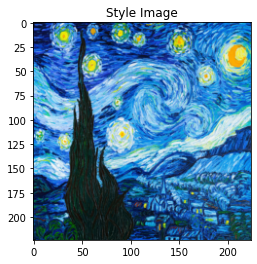

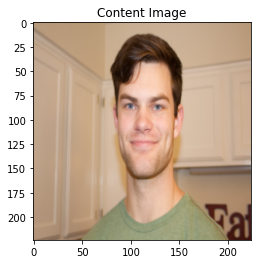

In [4]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [5]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [6]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", 
             "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3",
             "maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", 
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
style_layers = [0, 5, 11, 17, 25] # we choose these respective layers as described in text 
content_layers = [17]
chosen_layers = style_layers + content_layers # total layers 

# Create the vgg network in eval mode
# with our forward method that returns the outputs of the intermediate layers we requested
style_model = VGGIntermediate(requested=style_layers) # instantiate Style model 
content_model = VGGIntermediate(requested=content_layers) # instantiate content model 

style_model = style_model.cuda() # use GPU 
content_model = content_model.cuda()

# Cache the outputs of the content and style layers for their respective images

style_stats = style_model(style_image) # statistics for style 
content_stats = content_model(content_image) # and for content 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


___

### Part 2
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [7]:
def gram_matrix(input):
   a, b, c, d = input.size() # take the size 
   features = input.view(a * b, c * d) # resize 
   G = torch.mm(features, features.t())
   return G.div(a * b * c * d) # Calculate g - matrix and adjust for total size 
  
class ContentLoss(nn.Module):
  def __init__(self, target,): 
    super(ContentLoss, self).__init__()
    self.target = target.detach() # detach 

  def forward(self, input): 
    self.loss = F.mse_loss(input, self.target) # take mse loss of content 
    return self.loss # return as attribute 
    
class StyleLoss(nn.Module):
  def __init__(self, target_feature): 
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach() # gram matrix 

  def forward(self, input): 
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target) # mse loss of gram matrix and target 
    return self.loss # return as attribute 

# Instantiate a content loss module for each content layer 
# with the content reference image outputs for that layer for comparison

content_loss_conv1 = ContentLoss(content_stats[17]) # content loss for layer 17 

# Instantiate a style loss module for each style layer 
# with the style reference image outputs for that layer for comparison

style_loss_conv1 = StyleLoss(style_stats[0]) # style loss stats for layer 0 

style_loss_conv2 = StyleLoss(style_stats[5]) # style loss stats for layer 5 

style_loss_conv3 = StyleLoss(style_stats[11]) # style loss stats for layer 11

style_loss_conv4 = StyleLoss(style_stats[17]) # style loss stats for layer 17 

style_loss_conv5 = StyleLoss(style_stats[25]) # # style loss stats for layer 25 


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



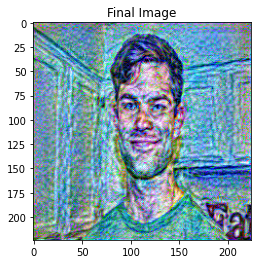

In [22]:
# Start with a copy of the content image
import copy 
input_image = content_image.clone().requires_grad_() # copy original image to input in model 

def get_optimizer(input):
  """ Adam optimizer """  
  optimizer = optim.Adam([input.requires_grad_()], lr = 0.1)
  return optimizer # return optimizer 

# Run the optimizer on the images to change the image
# using the loss of the style and content layers
# to backpropagate errors

# lists for our losses 
losses = []
content_losses = []
style_losses = []
optimizer = get_optimizer(input_image)
i = 0 # counter 
def run_model(style_weight = 10**3, content_weight = 1): 
  try: 
    for i in range(350): # iterate 150 times 

      optimizer.zero_grad() # set to zero 
      # call content/style classes 
      c_forward = content_model(input_image) 
      s_forward = style_model(input_image) 
      # update/call layers 
      s_layer0 = s_forward[0] 
      s_layer5 = s_forward[5]
      s_layer11 = s_forward[11]
      s_layer17 = s_forward[17] 
      s_layer25 = s_forward[25] 
      # and for content layer 
      c_layer17 = c_forward[17]
      # compute loss for each layer 
      loss1 = style_loss_conv1(s_layer0)
      loss2 = style_loss_conv2(s_layer5)
      loss3 = style_loss_conv3(s_layer11)
      loss4 = style_loss_conv4(s_layer17) 
      loss5 = style_loss_conv5(s_layer25) 
      c_loss = content_loss_conv1(c_layer17)
      # weight each layers loss by their respective weights 
      s_loss = style_weight * (loss1 + loss2 + loss3 + loss4 + loss5)
      c_loss = content_weight * c_loss 
      total_loss = s_loss + c_loss 
      # every 50 iterations, we take content and style losses and append to lists 
      if i % 50 == 0:
        content_losses.append((i, c_loss)) 
        style_losses.append((i, s_loss))
      i += 1

      losses.append((i, total_loss.item()))
      total_loss.backward()
      optimizer.step()
      # clamp to not go out of range 
      input_image.data.clamp_(0, 1) 
    return input_image 
  except: 
    input_image # return the new image 

 
# Show the image
output = run_model() # run model

# plot image 
display(output)
plt.title("Final Image") 
plt.show()

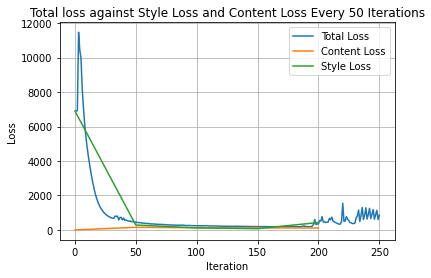

In [20]:
a, b = zip(*losses) # total losses 
plt.plot(a, b, label = "Total Loss")

a, b = zip(*content_losses) # content losses 
plt.plot(a, b, label = "Content Loss")

a, b = zip(*style_losses) # style losses 
plt.plot(a, b, label = "Style Loss")


# return with title, grid, legend, labels 
plt.title("Total loss against Style Loss and Content Loss Every 50 Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

### Part 4

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Equation 1:

Givel p - the original image, x - the input image, and l - the layer, we define equation one as half of the sum of squared differences of is the activation of the i-th filter at position j in layer l - F^l_(i,j) - and the feature reptresentation of the image of the i-th filter at position j in layer l - P^l_(i, j). This is the Loss function. 

Equation 3: 

This describes the inner product between the vectorised feature map i and j in layer l, summed over k, resulting in what is interpreted as how related $F^l_{ik}$ and $F^l_{jk}$ are (how the generated image's style matches the style-images style). ($F^l_{ik}$ is the activation of the i-th filter at position k in layer l, and $F^l_{jk}$ is the activation of the $j$-th filter at position k in layer l) 

Equation 4:

We have that for layer l, Nl is the number of feature maps and Ml is the hight X width of the feature map (the size of the feature map). We have that for Al and Gl, the style representations of the original and generated images respectively, we have that the formula finds how far off the style from the generated image is from the original image's style in layer l - hence, why we take the euclidean distance in a sum of squared differences. Further, the coefficient on the entire sum divides that distance by 4 times the squared number of feature maps in layer l times the square of the size of the l-th feature map (this tells us the loss relative to the size of the layer we are on). We call this El. 

Equation 5: 

Style loss. For El as given above for layer l, and wl - the weighting factors of the contribution of each layer to the total loss - we have that total style loss is the weighted sum of each layer's loss. That is, each style loss at layer l is weighted by its weighting factor (to adjust for how much that layer contributes overall to the loss) and these values are added together as the sum total of each layers loss. This is called L-style. It tells us the total sum of losses at each layer l weighted by how much each layer contributes overall to our loss. 